In [10]:
import sys
try:
    import dask
    import dask.dataframe as dd
    print(f"Dask version: {dask.__version__}")
    print("Dask dataframe imported successfully.")
except ImportError as e:
    print(f"Error importing dask: {e}")
    sys.exit(1)

try:
    import torch
    print(f"Torch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
except ImportError as e:
    print(f"Error importing torch: {e}")


Dask version: 2025.11.0
Dask dataframe imported successfully.
Torch version: 2.9.1+cu128
CUDA available: True


# Documentación del Modelo de Predicción de Tráfico (ST-DenseNet)

Este documento detalla la arquitectura, formulación matemática y metodología utilizada en el modelo de predicción de tráfico celular (Internet) para la ciudad de Milán. El modelo se basa en una arquitectura **ST-DenseNet** (Spatio-Temporal Densely Connected Convolutional Network).

## 1. Definición del Problema

El objetivo es predecir el volumen de tráfico de Internet (entrante y saliente) para cada celda de una cuadrícula de $100 \times 100$ en la ciudad de Milán para el siguiente intervalo de tiempo, basándose en datos históricos.

Sea $X_t \in \mathbb{R}^{2 \times 100 \times 100}$ el tensor de tráfico en el tiempo $t$, donde el canal 0 representa `internetin` y el canal 1 representa `internetout`. El objetivo es aprender una función $f$ tal que:

$$ \hat{X}_{t} = f(X_{t-1}, X_{t-2}, \dots, X_{t-n}) $$

In [11]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración del Dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Parámetros del Modelo
H, W = 100, 100  # Dimensiones de la cuadrícula
LEN_CLOSE = 3    # Dependencia de proximidad (p)
LEN_PERIOD = 3   # Dependencia de periodo (q)
NB_FLOW = 1      # Canales (SMS In, SMS Out)

# Parámetros de Entrenamiento
BATCH_SIZE = 8 # Reducido para evitar Kernel Crash (OOM)
EPOCHS = 100
LEARNING_RATE = 0.01

Usando dispositivo: cuda
GPU: NVIDIA GeForce RTX 5080


## 2. Preprocesamiento de Datos

### 2.1. Agregación Espacio-Temporal
Los datos crudos se agregan espacialmente en una rejilla de $H \times W$ ($100 \times 100$) y temporalmente en intervalos de 1 hora.

### 2.2. Normalización Z-Score (Estandarización)
Para facilitar la convergencia del entrenamiento, los datos se normalizan al rango $[0, 1]$ utilizando la transformación Min-Max:

$$ x'_{i} = \frac{x_i - \min(X)}{\max(X) - \min(X)} $$

Donde $x_i$ es el valor de tráfico en una celda y tiempo específico, y $X$ es el conjunto total de datos de entrenamiento.

In [12]:

import os
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

# 0. Definir tipos de datos para ahorrar RAM desde el inicio
dtypes = {
    'TimeInterval': 'int64',
    'GridID': 'int32',
    'internet': 'float32'
}

# 1. Buscar archivos válidos
files = [f'../data{i}.csv/data{i}.csv' for i in range(1, 8)]
valid_files = [f for f in files if os.path.exists(f)]

print(f"Archivos encontrados: {len(valid_files)}")
print("Cargando datos con dtypes optimizados...")

# 2. Cargar solo las columnas necesarias y con dtypes eficientes
ddf = dd.read_csv(
    valid_files, 
    usecols=['TimeInterval', 'GridID', 'internet'],
    dtype=dtypes,
    assume_missing=True
)

# 3. Convertir tiempo (Optimizamos para no saturar RAM)
# Convertimos el int64 (ms) a datetime de forma más directa
ddf['Timestamp'] = dd.to_datetime(ddf['TimeInterval'], unit='ms')
ddf['Hour'] = ddf['Timestamp'].dt.floor('h')

# 4. Agregación (Agregamos Hour y GridID)
print("Preparando tarea de agregación...")
agg_task = ddf.groupby(['Hour', 'GridID'])[['internet']].sum()

# 5. Ejecutar computación (Usamos cache de dask o limitamos si es necesario)
print("Iniciando computación (esto puede tardar unos minutos)...")
with ProgressBar():
    # compute() puede fallar si el resultado final es mayor que la RAM libre.
    # Pero con dtypes float32/int32 debería caber mucho mejor.
    df_agg = agg_task.compute().reset_index()

# 6. Limpiar ddf de memoria para liberar espacio
del ddf
import gc
gc.collect()

print("\nAgregación completada con éxito.")
print(f"Tamaño final: {df_agg.shape}")
print(df_agg.head())


Archivos encontrados: 2
Cargando datos con dtypes optimizados...
Preparando tarea de agregación...
Iniciando computación (esto puede tardar unos minutos)...
[########################################] | 100% Completed | 72.50 s

Agregación completada con éxito.
Tamaño final: (14877485, 3)
                 Hour  GridID   internet
0 2013-12-30 23:00:00     331  42.915188
1 2013-12-30 23:00:00     378  72.726486
2 2013-12-30 23:00:00     408  38.371372
3 2013-12-30 23:00:00     427  42.917561
4 2013-12-30 23:00:00    3248  65.601387


In [13]:
# --- CONSTRUCCIÓN DE LA MATRIZ 4D (Time, Channels, H, W) ---

# Filtrar GridIDs válidos (1 a 10000)
df_agg = df_agg[(df_agg['GridID'] >= 1) & (df_agg['GridID'] <= 10000)]

# Crear índice temporal completo
min_time = df_agg['Hour'].min()
max_time = df_agg['Hour'].max()
time_range = pd.date_range(min_time, max_time, freq='H')

print(f"Rango temporal: {min_time} a {max_time} ({len(time_range)} horas)")

# Inicializar tensor gigante: [Time, 2, 100, 100]
data_tensor = np.zeros((len(time_range), 1, 100, 100), dtype=np.float32)

# Mapeo de tiempo a índice
time_to_idx = {t: i for i, t in enumerate(time_range)}

print("Rellenando tensor 4D...")
# Iterar y rellenar (esto puede ser lento en Python puro, pero pandas lo facilita)
# Pivotar tabla para tener GridID como columnas
df_pivot = df_agg.pivot_table(index='Hour', columns='GridID', values=['internet'], fill_value=0)

# Rellenar el tensor
for t in time_range:
    if t in df_pivot.index:
        idx = time_to_idx[t]
        # internet
        vals = df_pivot.loc[t, 'internet'].reindex(range(1, 10001), fill_value=0).values
        data_tensor[idx, 0, :, :] = vals.reshape(100, 100)
print(f"Tensor shape: {data_tensor.shape}")

Rango temporal: 2013-10-31 23:00:00 a 2014-01-01 22:00:00 (1488 horas)
Rellenando tensor 4D...
Tensor shape: (1488, 1, 100, 100)


In [14]:

# --- NORMALIZACIÓN Z-SCORE (Standardization) ---
data_mean = data_tensor.mean()
data_std = data_tensor.std()

print(f"Original Mean: {data_mean:.4f}, Original Std: {data_std:.4f}")

# Z-Score: (X - Mean) / Std
data_norm = (data_tensor - data_mean) / (data_std + 1e-5)

print(f"Norm Mean: {data_norm.mean():.4f}, Norm Std: {data_norm.std():.4f}")
print(f"Norm Min: {data_norm.min():.4f}, Norm Max: {data_norm.max():.4f}")


Original Mean: 373.1783, Original Std: 723.2927
Norm Mean: 0.0000, Norm Std: 1.0000
Norm Min: -0.5159, Norm Max: 55.1358


### 2.3. Construcción de Entradas (Dependencias Temporales)
El modelo captura dos tipos de dependencias temporales:

1.  **Cercanía (Closeness - $X_c$)**: Captura la tendencia reciente. Se toman los últimos $l_c$ intervalos de tiempo.
    $$ X_c = [X_{t-l_c}, X_{t-(l_c-1)}, \dots, X_{t-1}] $$
    
2.  **Periodo (Period - $X_d$)**: Captura la periodicidad diaria (mismo hora del día en días anteriores). Se toman $l_p$ días.
    $$ X_d = [X_{t-l_p \cdot 24}, X_{t-(l_p-1) \cdot 24}, \dots, X_{t-24}] $$

In [15]:
# --- GENERACIÓN DE DATASET (Ventana Deslizante) ---

def create_dataset(data, len_c, len_p):
    # data: [T, C, H, W]
    T, C, H, W = data.shape
    
    XC, XD, Y = [], [], []
    
    # Empezamos después de tener suficiente historia para Periodo (que es el más largo)
    # Periodo necesita: t - len_p * 24
    start_idx = len_p * 24
    
    print("Generando dataset (Ventana Deslizante)...")
    for i in range(start_idx, T):
        # Target
        y = data[i] # [C, H, W]
        
        # Proximidad (Close): últimos len_c horas
        # [i-len_c, ..., i-1]
        xc = data[i - len_c : i] # [len_c, C, H, W]
        # Concatenar en canales: [len_c * C, H, W]
        xc = np.concatenate(xc, axis=0)
        
        # Periodo (Period): misma hora días anteriores
        # [i - len_p*24, ..., i - 24]
        xd = []
        for p in range(len_p, 0, -1):
            idx = i - p * 24
            xd.append(data[idx])
        xd = np.concatenate(xd, axis=0) # [len_p * C, H, W]
        
        XC.append(xc)
        XD.append(xd)
        Y.append(y)
        
    return np.array(XC), np.array(XD), np.array(Y)

print("Generando tensores Xc, Xd, Y...")
XC, XD, Y = create_dataset(data_norm, LEN_CLOSE, LEN_PERIOD)
print(f"XC shape: {XC.shape}")
print(f"XD shape: {XD.shape}")
print(f"Y shape:  {Y.shape}")

Generando tensores Xc, Xd, Y...
Generando dataset (Ventana Deslizante)...
XC shape: (1416, 3, 100, 100)
XD shape: (1416, 3, 100, 100)
Y shape:  (1416, 1, 100, 100)


In [16]:
# --- DIVISIÓN TRAIN / TEST ---
# Test = Últimos 7 días (7 * 24 horas = 168 horas)
test_hours = 7 * 24
total_samples = len(Y)
train_samples = total_samples - test_hours

XC_train, XD_train, Y_train = XC[:train_samples], XD[:train_samples], Y[:train_samples]
XC_test, XD_test, Y_test = XC[train_samples:], XD[train_samples:], Y[train_samples:]

print(f"Train samples: {len(Y_train)}")
print(f"Test samples:  {len(Y_test)}")

# Convertir a Tensores PyTorch
train_data = TensorDataset(torch.from_numpy(XC_train).float(), torch.from_numpy(XD_train).float(), torch.from_numpy(Y_train).float())
test_data = TensorDataset(torch.from_numpy(XC_test).float(), torch.from_numpy(XD_test).float(), torch.from_numpy(Y_test).float())

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

Train samples: 1248
Test samples:  168


El enfoque principal del estudio es proponer una arquitectura de **Red Neuronal Convolucional Densely Connected (Densely Connected CNN)** para modelar colectivamente las complejas dependencias espaciales y temporales del tráfico celular.

Esta arquitectura, considerada como el modelo de aprendizaje profundo más avanzado en este contexto, está diseñada específicamente para superar las limitaciones de los modelos estadísticos lineales y de los enfoques de aprendizaje automático que se centran únicamente en celdas individuales.

A continuación, se detalla la arquitectura del modelo de predicción, siguiendo la descripción provista en las fuentes:

---

## Arquitectura del Modelo: Redes Neuronales Convolucionales Densely Connected

El marco de predicción se ilustra conceptualmente en la Figura 2 (mencionada en las fuentes) y consta principalmente de tres componentes: construcción de datos de entrenamiento (que genera los tensores de entrada $X_c$ y $X_d$), el aprendizaje convolucional y la fusión basada en matriz paramétrica.

### I. Diseño de Doble Red con Estructura Compartida

La arquitectura se compone de **dos redes** con una **estructura compartida**. Esta dualidad es fundamental para modelar la dependencia temporal del tráfico:

1.  **Red de Proximidad (Closeness):** Utiliza el tensor de entrada $X_c$ para modelar la **dependencia temporal de corto alcance** (tráfico reciente).
2.  **Red de Periodo (Period):** Utiliza el tensor de entrada $X_d$ para modelar la **dependencia temporal de largo alcance** (historia diaria o patrones periódicos).

### II. Componentes de las Capas y Conexiones Densas

Dentro de cada una de las dos redes, la arquitectura implementa el patrón **Densely Connected**:

#### A. Operación de Conexión Densa ($\oplus$)

El patrón *Densely Connected* se adopta para mitigar el problema del gradiente evanescente y para fortalecer la propagación de características.

*   En la $l$-ésima capa, la salida ($X^l$) es la transformación no lineal ($f_l$) de la concatenación ($\oplus$) de los mapas de características producidos en **todas las capas precedentes**.
*   Para la dependencia de proximidad, esto se expresa matemáticamente como:
    $$X^l_c = f_l(X^0_c \oplus X^1_c \oplus \cdots \oplus X^{l-1}_c) \quad \text{}$$

#### B. Componentes de Capa ($f_l(\cdot)$)

Cada capa $l$ implementa una **transformación no lineal** $f_l(\cdot)$ que es una función compuesta por tres operaciones consecutivas:

1.  **Convolución (Conv):** Utiliza filtros para fusionar la información de celdas vecinas y capturar la dependencia espacial de manera jerárquica.
    *   **Configuración General:** Casi todas las capas de convolución tienen **32 filtros con un tamaño de $3 \times 3$**.
    *   **Capa Final:** La última capa (previa a la fusión) tiene **2 filtros con un tamaño de $3 \times 3$**.
2.  **Normalización por Lotes (BN):** Ayuda a estabilizar el proceso de aprendizaje.
3.  **Unidades Lineales Rectificadas (ReLU):** Es la función de activación no lineal que decide si una neurona debe activarse o no, calculando la suma ponderada de su entrada.

### III. Fusión Basada en Matriz Paramétrica (Parametric Matrix Based Fusion)

La fase final de la arquitectura consiste en un esquema de fusión diseñado para combinar las características extraídas de las dos redes, reconociendo que la relevancia de la proximidad y el periodo **varía**.

#### A. Capa Pre-Fusión
Primero, se añade una capa de convolución separada en la parte superior de la $L$-ésima capa de ambas redes para obtener las características que se utilizarán en el esquema de fusión paramétrica. Las salidas de estas capas son denotadas como $X^{L+1}_c$ y $X^{L+1}_d$.

#### B. Fórmula de Fusión
La salida intermedia fusionada ($X_o$) se calcula mediante la siguiente fórmula:
$$X_o = W_c \odot X^{L+1}_c + W_d \odot X^{L+1}_d \quad \text{}$$

*   **Producto de Hadamard ($\odot$):** Es la multiplicación elemento a elemento.
*   **$W_c$ y $W_d$:** Son **parámetros aprendibles** (*learnable parameters*) que caracterizan el grado de influencia de la dependencia de proximidad y periodo, respectivamente, en la predicción del tráfico inalámbrico.

#### C. Activación Final
La predicción final del tráfico ($\hat{X}_t$) se obtiene aplicando la función **Sigmoide ($\sigma$)** a la salida fusionada:
$$\hat{X}_t = \sigma(X_o) \quad \text{}$$
(Se utiliza la Sigmoide debido a que el tráfico de entrada fue escalado previamente al rango $$ mediante la normalización Min-Max).

En resumen, la arquitectura Densely Connected CNN utiliza una estructura de doble rama para procesar las dos dimensiones temporales, emplea la convolución para modelar las correlaciones espaciales dentro de cada rama, y utiliza un mecanismo de fusión paramétrico para aprender la contribución relativa de cada dependencia temporal en la predicción final.

In [17]:
class DenseUnit(nn.Module):
    def __init__(self, in_channels, out_channels=32):
        super(DenseUnit, self).__init__()
        # Text specifies: Conv -> BN -> ReLU
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        # Concatenar entrada y salida (Conexión Densa)
        return torch.cat([x, out], 1)

class DenseBlock(nn.Module):
    def __init__(self, in_channels, num_layers=3, growth_rate=32):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        current_channels = in_channels
        for _ in range(num_layers):
            self.layers.append(DenseUnit(current_channels, growth_rate))
            current_channels += growth_rate
            
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class STDenseNet(nn.Module):
    def __init__(self, len_c, len_p, nb_flow, growth_rate=32):
        super(STDenseNet, self).__init__()
        
        # Input channels for each branch
        c_in = len_c * nb_flow
        p_in = len_p * nb_flow
        
        # --- Branch Proximity (Close) ---
        # Entrada -> Conv -> DenseBlock -> Conv
        self.c_conv1 = nn.Conv2d(c_in, growth_rate, kernel_size=3, padding=1)
        self.c_dense = DenseBlock(growth_rate, num_layers=3, growth_rate=growth_rate)
        # Output channels after dense block: growth_rate + 3 * growth_rate = 4 * 32 = 128
        dense_out_c = growth_rate + 3 * growth_rate
        self.c_conv2 = nn.Conv2d(dense_out_c, nb_flow, kernel_size=3, padding=1)
        
        # --- Branch Period ---
        self.p_conv1 = nn.Conv2d(p_in, growth_rate, kernel_size=3, padding=1)
        self.p_dense = DenseBlock(growth_rate, num_layers=3, growth_rate=growth_rate)
        self.p_conv2 = nn.Conv2d(dense_out_c, nb_flow, kernel_size=3, padding=1)
        
        # --- Fusion ---
        # Parametric Matrix Fusion: Wc * Xc + Wd * Xd
        # Wc, Wd are learnable parameters of shape (nb_flow, H, W)
        self.Wc = nn.Parameter(torch.randn(nb_flow, H, W), requires_grad=True)
        self.Wd = nn.Parameter(torch.randn(nb_flow, H, W), requires_grad=True)
        
        # Output Activation

    def forward(self, xc, xd):
        # Proximity Branch
        out_c = self.c_conv1(xc)
        out_c = self.c_dense(out_c)
        out_c = self.c_conv2(out_c)
        
        # Period Branch
        out_p = self.p_conv1(xd)
        out_p = self.p_dense(out_p)
        out_p = self.p_conv2(out_p)
        
        # Fusion
        fusion = out_c * self.Wc + out_p * self.Wd
        
        # Output
        return fusion # Linear activation for Z-Score


## 4. Entrenamiento

### 4.1. Función de Pérdida (Loss Function)
Se utiliza el Error Cuadrático Medio (MSE) entre la predicción y el valor real:

$$ L(\theta) = \frac{1}{N} \sum_{i=1}^{N} || \hat{X}_t^{(i)} - X_t^{(i)} ||^2 $$

Donde $\theta$ son todos los parámetros aprendibles del modelo.

### 4.2. Optimizador
*   **Algoritmo**: Adam (Adaptive Moment Estimation).
*   **Learning Rate**: Se utiliza un esquema de decaimiento (MultiStepLR) que reduce la tasa de aprendizaje en épocas específicas (50 y 75) para refinar la convergencia.

Instanciando modelo STDenseNet en: cuda
Iniciando entrenamiento...


Epoch 1/100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:02<00:00, 55.39it/s, loss=0.95127]


Epoch 1/100, Loss: 4.018480


Epoch 2/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 174.13it/s, loss=0.91780]


Epoch 2/100, Loss: 0.945059


Epoch 3/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 176.54it/s, loss=0.99282]


Epoch 3/100, Loss: 0.760912


Epoch 4/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 179.71it/s, loss=0.56185]


Epoch 4/100, Loss: 0.581246


Epoch 5/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 176.82it/s, loss=0.40058]


Epoch 5/100, Loss: 0.454688


Epoch 6/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 168.09it/s, loss=0.33862]


Epoch 6/100, Loss: 0.384512


Epoch 7/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 164.42it/s, loss=0.28485]


Epoch 7/100, Loss: 0.318369


Epoch 8/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 167.74it/s, loss=0.35740]


Epoch 8/100, Loss: 0.273147


Epoch 9/100: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 172.75it/s, loss=0.19644]


Epoch 9/100, Loss: 0.241649


Epoch 10/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 168.26it/s, loss=0.17938]


Epoch 10/100, Loss: 0.226095


Epoch 11/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 161.82it/s, loss=0.19448]


Epoch 11/100, Loss: 0.198615


Epoch 12/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 146.10it/s, loss=0.15801]


Epoch 12/100, Loss: 0.175271


Epoch 13/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 145.35it/s, loss=0.13598]


Epoch 13/100, Loss: 0.161231


Epoch 14/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 141.22it/s, loss=0.16800]


Epoch 14/100, Loss: 0.145457


Epoch 15/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 135.07it/s, loss=0.13078]


Epoch 15/100, Loss: 0.130247


Epoch 16/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 142.38it/s, loss=0.09696]


Epoch 16/100, Loss: 0.119175


Epoch 17/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 130.21it/s, loss=0.09343]


Epoch 17/100, Loss: 0.111352


Epoch 18/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 152.13it/s, loss=0.08218]


Epoch 18/100, Loss: 0.102183


Epoch 19/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 153.35it/s, loss=0.13229]


Epoch 19/100, Loss: 0.097708


Epoch 20/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 149.61it/s, loss=0.07830]


Epoch 20/100, Loss: 0.094018


Epoch 21/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 156.07it/s, loss=0.06411]


Epoch 21/100, Loss: 0.088751


Epoch 22/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 154.81it/s, loss=0.06173]


Epoch 22/100, Loss: 0.085786


Epoch 23/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 154.10it/s, loss=0.05813]


Epoch 23/100, Loss: 0.085557


Epoch 24/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 146.65it/s, loss=0.07995]


Epoch 24/100, Loss: 0.081633


Epoch 25/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 128.83it/s, loss=0.07239]


Epoch 25/100, Loss: 0.075390


Epoch 26/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 135.89it/s, loss=0.07924]


Epoch 26/100, Loss: 0.072030


Epoch 27/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 157.34it/s, loss=0.06694]


Epoch 27/100, Loss: 0.072452


Epoch 28/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 149.65it/s, loss=0.07520]


Epoch 28/100, Loss: 0.071574


Epoch 29/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 153.10it/s, loss=0.07153]


Epoch 29/100, Loss: 0.070072


Epoch 30/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 164.02it/s, loss=0.06689]


Epoch 30/100, Loss: 0.064014


Epoch 31/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 162.20it/s, loss=0.07001]


Epoch 31/100, Loss: 0.063308


Epoch 32/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 168.53it/s, loss=0.08360]


Epoch 32/100, Loss: 0.065134


Epoch 33/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 179.34it/s, loss=0.06355]


Epoch 33/100, Loss: 0.062695


Epoch 34/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 165.42it/s, loss=0.08803]


Epoch 34/100, Loss: 0.062811


Epoch 35/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 159.19it/s, loss=0.04951]


Epoch 35/100, Loss: 0.064694


Epoch 36/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 147.57it/s, loss=0.07994]


Epoch 36/100, Loss: 0.057585


Epoch 37/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 171.86it/s, loss=0.04980]


Epoch 37/100, Loss: 0.056363


Epoch 38/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 177.33it/s, loss=0.04186]


Epoch 38/100, Loss: 0.055954


Epoch 39/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 173.66it/s, loss=0.05555]


Epoch 39/100, Loss: 0.055714


Epoch 40/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 169.49it/s, loss=0.05025]


Epoch 40/100, Loss: 0.055265


Epoch 41/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 166.89it/s, loss=0.04985]


Epoch 41/100, Loss: 0.055193


Epoch 42/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 156.57it/s, loss=0.04397]


Epoch 42/100, Loss: 0.053450


Epoch 43/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 159.98it/s, loss=0.05179]


Epoch 43/100, Loss: 0.052370


Epoch 44/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 147.86it/s, loss=0.07106]


Epoch 44/100, Loss: 0.048729


Epoch 45/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 130.01it/s, loss=0.05003]


Epoch 45/100, Loss: 0.050079


Epoch 46/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 132.03it/s, loss=0.05023]


Epoch 46/100, Loss: 0.049600


Epoch 47/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 127.57it/s, loss=0.04387]


Epoch 47/100, Loss: 0.048879


Epoch 48/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 141.11it/s, loss=0.02964]


Epoch 48/100, Loss: 0.049990


Epoch 49/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 147.27it/s, loss=0.04392]


Epoch 49/100, Loss: 0.047553


Epoch 50/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 146.03it/s, loss=0.07385]


Epoch 50/100, Loss: 0.048743


Epoch 51/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 164.20it/s, loss=0.04276]


Epoch 51/100, Loss: 0.040897


Epoch 52/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 169.95it/s, loss=0.03216]


Epoch 52/100, Loss: 0.039818


Epoch 53/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 169.74it/s, loss=0.03593]


Epoch 53/100, Loss: 0.039580


Epoch 54/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 162.58it/s, loss=0.03792]


Epoch 54/100, Loss: 0.039442


Epoch 55/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 162.52it/s, loss=0.02744]


Epoch 55/100, Loss: 0.039282


Epoch 56/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 166.26it/s, loss=0.04155]


Epoch 56/100, Loss: 0.039752


Epoch 57/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 160.80it/s, loss=0.03807]


Epoch 57/100, Loss: 0.038921


Epoch 58/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 158.89it/s, loss=0.03383]


Epoch 58/100, Loss: 0.039297


Epoch 59/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 171.41it/s, loss=0.05446]


Epoch 59/100, Loss: 0.039103


Epoch 60/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 169.49it/s, loss=0.03789]


Epoch 60/100, Loss: 0.039146


Epoch 61/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 173.86it/s, loss=0.05099]


Epoch 61/100, Loss: 0.038627


Epoch 62/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 174.01it/s, loss=0.03239]


Epoch 62/100, Loss: 0.038841


Epoch 63/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 174.91it/s, loss=0.03558]


Epoch 63/100, Loss: 0.038695


Epoch 64/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 172.14it/s, loss=0.03625]


Epoch 64/100, Loss: 0.038512


Epoch 65/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 166.98it/s, loss=0.04323]


Epoch 65/100, Loss: 0.038802


Epoch 66/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 167.95it/s, loss=0.04116]


Epoch 66/100, Loss: 0.038195


Epoch 67/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 167.28it/s, loss=0.03364]


Epoch 67/100, Loss: 0.038401


Epoch 68/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 168.35it/s, loss=0.02628]


Epoch 68/100, Loss: 0.038280


Epoch 69/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 158.10it/s, loss=0.04231]


Epoch 69/100, Loss: 0.038277


Epoch 70/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 155.15it/s, loss=0.05485]


Epoch 70/100, Loss: 0.037741


Epoch 71/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 162.99it/s, loss=0.02749]


Epoch 71/100, Loss: 0.038014


Epoch 72/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 172.76it/s, loss=0.04142]


Epoch 72/100, Loss: 0.037842


Epoch 73/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 156.51it/s, loss=0.04112]


Epoch 73/100, Loss: 0.037662


Epoch 74/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 139.98it/s, loss=0.02965]


Epoch 74/100, Loss: 0.037666


Epoch 75/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 146.00it/s, loss=0.02707]


Epoch 75/100, Loss: 0.037589


Epoch 76/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 141.08it/s, loss=0.03038]


Epoch 76/100, Loss: 0.037051


Epoch 77/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 146.71it/s, loss=0.03208]


Epoch 77/100, Loss: 0.037117


Epoch 78/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 131.75it/s, loss=0.03785]


Epoch 78/100, Loss: 0.037081


Epoch 79/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 124.41it/s, loss=0.03241]


Epoch 79/100, Loss: 0.037287


Epoch 80/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 127.76it/s, loss=0.03630]


Epoch 80/100, Loss: 0.037129


Epoch 81/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 125.17it/s, loss=0.03613]


Epoch 81/100, Loss: 0.037134


Epoch 82/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 122.21it/s, loss=0.04165]


Epoch 82/100, Loss: 0.037074


Epoch 83/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 125.47it/s, loss=0.02782]


Epoch 83/100, Loss: 0.037121


Epoch 84/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 134.48it/s, loss=0.04445]


Epoch 84/100, Loss: 0.037008


Epoch 85/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:01<00:00, 153.34it/s, loss=0.03667]


Epoch 85/100, Loss: 0.036775


Epoch 86/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 172.33it/s, loss=0.03138]


Epoch 86/100, Loss: 0.037034


Epoch 87/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 168.68it/s, loss=0.03090]


Epoch 87/100, Loss: 0.037095


Epoch 88/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 170.29it/s, loss=0.03179]


Epoch 88/100, Loss: 0.036833


Epoch 89/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 175.06it/s, loss=0.04871]


Epoch 89/100, Loss: 0.037070


Epoch 90/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 169.47it/s, loss=0.04104]


Epoch 90/100, Loss: 0.036831


Epoch 91/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 173.66it/s, loss=0.03202]


Epoch 91/100, Loss: 0.036633


Epoch 92/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 173.26it/s, loss=0.03478]


Epoch 92/100, Loss: 0.036917


Epoch 93/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 170.03it/s, loss=0.04267]


Epoch 93/100, Loss: 0.036609


Epoch 94/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 162.82it/s, loss=0.03123]


Epoch 94/100, Loss: 0.036817


Epoch 95/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 159.63it/s, loss=0.03021]


Epoch 95/100, Loss: 0.036755


Epoch 96/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 162.04it/s, loss=0.02496]


Epoch 96/100, Loss: 0.036825


Epoch 97/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 180.06it/s, loss=0.03186]


Epoch 97/100, Loss: 0.036814


Epoch 98/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 177.75it/s, loss=0.03224]


Epoch 98/100, Loss: 0.036668


Epoch 99/100: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 166.06it/s, loss=0.04495]


Epoch 99/100, Loss: 0.036742


Epoch 100/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 156.14it/s, loss=0.02805]


Epoch 100/100, Loss: 0.036746


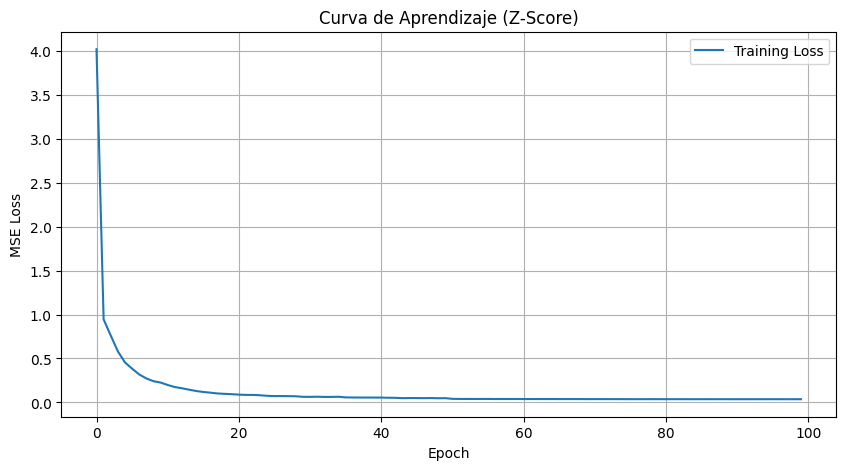

In [19]:
# --- ENTRENAMIENTO ROBUSTO (Gradient Accumulation + AMP) ---
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

# 1. Instanciar el modelo (Aseguramos que 'model' existe)
print(f"Instanciando modelo STDenseNet en: {DEVICE}")
model = STDenseNet(LEN_CLOSE, LEN_PERIOD, NB_FLOW).to(DEVICE)

# 2. Configuración de Entrenamiento
ACCUMULATION_STEPS = 4 # 8 * 4 = 32 (Equivalente al batch original)
scaler = GradScaler()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

print(f"Iniciando entrenamiento...")
train_losses = []

model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    optimizer.zero_grad() # Limpiar gradientes al inicio de la época
    for i, (xc, xd, y) in enumerate(pbar):
        xc, xd, y = xc.to(DEVICE), xd.to(DEVICE), y.to(DEVICE)
        
        # Uso de Mixed Precision (AMP) para ahorrar VRAM
        with autocast():
            output = model(xc, xd)
            loss = criterion(output, y)
            loss = loss / ACCUMULATION_STEPS # Normalizar para la acumulación
        
        # Backward escalado
        scaler.scale(loss).backward()
        
        # Actualizar pesos solo cada N pasos (Gradient Accumulation)
        if (i + 1) % ACCUMULATION_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
        epoch_loss += loss.item() * ACCUMULATION_STEPS
        pbar.set_postfix({'loss': f"{loss.item() * ACCUMULATION_STEPS:.5f}"})
        
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")
    
    # Limpieza de cache crítica para evitar Kernel Death
    torch.cuda.empty_cache()

# Visualizar curva de aprendizaje
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Curva de Aprendizaje (Z-Score)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

## 5. Interpretación de Resultados

### 5.1. Métricas de Evaluación
Para evaluar el rendimiento, primero se **desnormalizan** las predicciones para volver a la escala original de tráfico (número de Internet).

$$ \hat{X}_{orig} = \hat{X}_{norm} \cdot (Max - Min) + Min $$

Se calculan las siguientes métricas:

1.  **RMSE (Root Mean Squared Error)**: Error cuadrático medio. Penaliza más los errores grandes.
    $$ RMSE = \sqrt{\frac{1}{M} \sum (\hat{x}_{orig} - x_{orig})^2} $$

2.  **MAE (Mean Absolute Error)**: Error absoluto medio. Es más robusto a outliers y fácil de interpretar (error promedio en Internet).
    $$ MAE = \frac{1}{M} \sum |\hat{x}_{orig} - x_{orig}| $$

3.  **R2 Score**: Coeficiente de determinación. Indica qué tan bien las predicciones se ajustan a los datos reales (1.0 es perfecto).

### 5.2. Visualización
*   **Scatter Plot**: Gráfico de dispersión de Predicción vs Realidad. Idealmente, los puntos deberían alinearse en la diagonal.
*   **Distribución de Errores**: Histograma de los residuos. Debería estar centrado en 0.
*   **Mapa de Calor de Error**: Muestra dónde se concentran los errores espacialmente.
*   **Serie Temporal**: Comparación visual de la predicción y la realidad a lo largo del tiempo para una celda específica.

Iniciando evaluación...
Resultados de Evaluación:
RMSE: 114.0997
MAE:  48.5189
R2:   0.9058
Visualizando serie temporal para la celda con más tráfico: (51, 60)


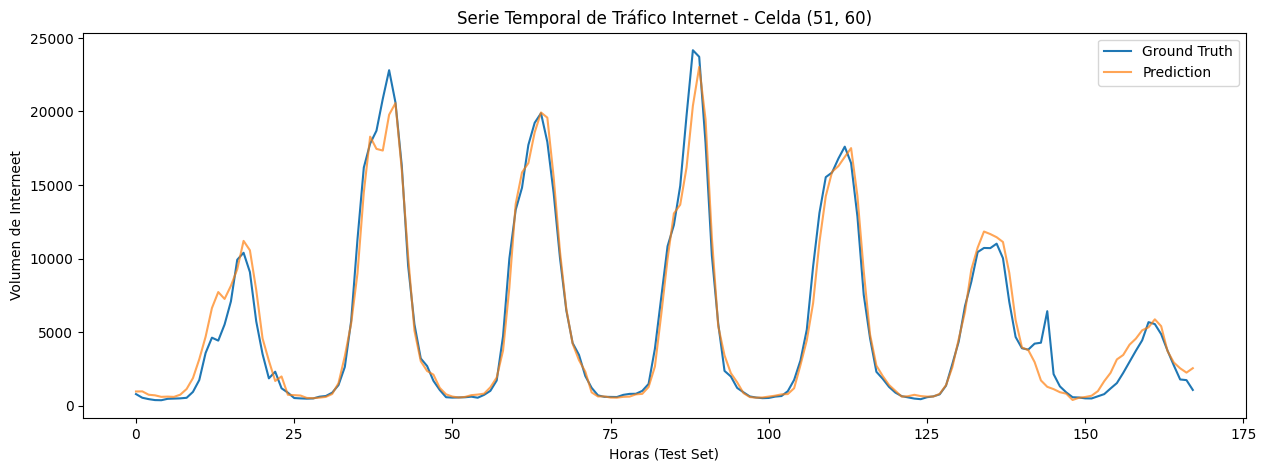

In [20]:
model.eval()
predictions = []
ground_truth = []

print("Iniciando evaluación...")
with torch.no_grad():
    for xc, xd, y in test_loader:
        xc, xd, y = xc.to(DEVICE), xd.to(DEVICE), y.to(DEVICE)
        output = model(xc, xd)
        predictions.append(output.cpu().numpy())
        ground_truth.append(y.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
ground_truth = np.concatenate(ground_truth, axis=0)

# Rescalado Inverso (Denormalization)
preds_rescaled = predictions * data_std + data_mean
gt_rescaled = ground_truth * data_std + data_mean

# --- MÉTRICAS ---
mse = mean_squared_error(gt_rescaled.flatten(), preds_rescaled.flatten())
rmse = np.sqrt(mse)
mae = mean_absolute_error(gt_rescaled.flatten(), preds_rescaled.flatten())
r2 = r2_score(gt_rescaled.flatten(), preds_rescaled.flatten())

print(f"Resultados de Evaluación:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")

# 4. Serie Temporal para la Celda con más Tráfico
total_traffic = np.sum(gt_rescaled, axis=(0, 1))
y_max, x_max = np.unravel_index(np.argmax(total_traffic), total_traffic.shape)

print(f"Visualizando serie temporal para la celda con más tráfico: ({y_max}, {x_max})")

gt_series = gt_rescaled[:, 0, y_max, x_max] # Channel 0 (SMS In)
pred_series = preds_rescaled[:, 0, y_max, x_max]

plt.figure(figsize=(15, 5))
plt.plot(gt_series, label='Ground Truth')
plt.plot(pred_series, label='Prediction', alpha=0.7)
plt.title(f'Serie Temporal de Tráfico Internet - Celda ({y_max}, {x_max})')
plt.xlabel('Horas (Test Set)')
plt.ylabel('Volumen de Interneet')
plt.legend()
plt.show()



Calculando métricas finales (Modo Ahorro de RAM)...

Resultados de Evaluación:
RMSE: 113.3157
MAE:  48.1764
Accuracy (1-WMAPE): 80.1269%
Visualizando nodo crítico (Max Tráfico): 5160


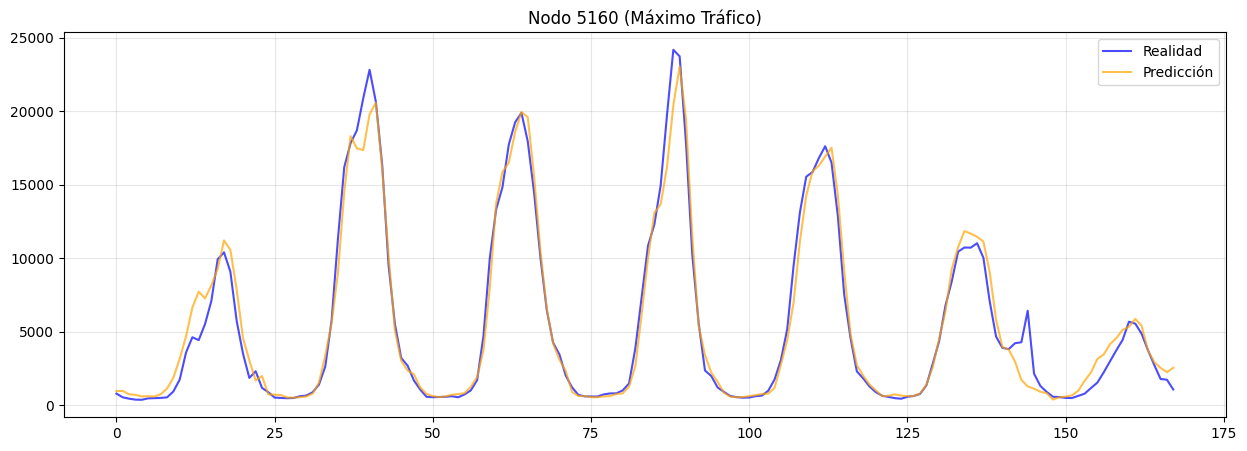

Visualizando 10 celdas aleatorias: [ 444 2861 7273 8728 9650 8934 5529 7178 5735 4741]


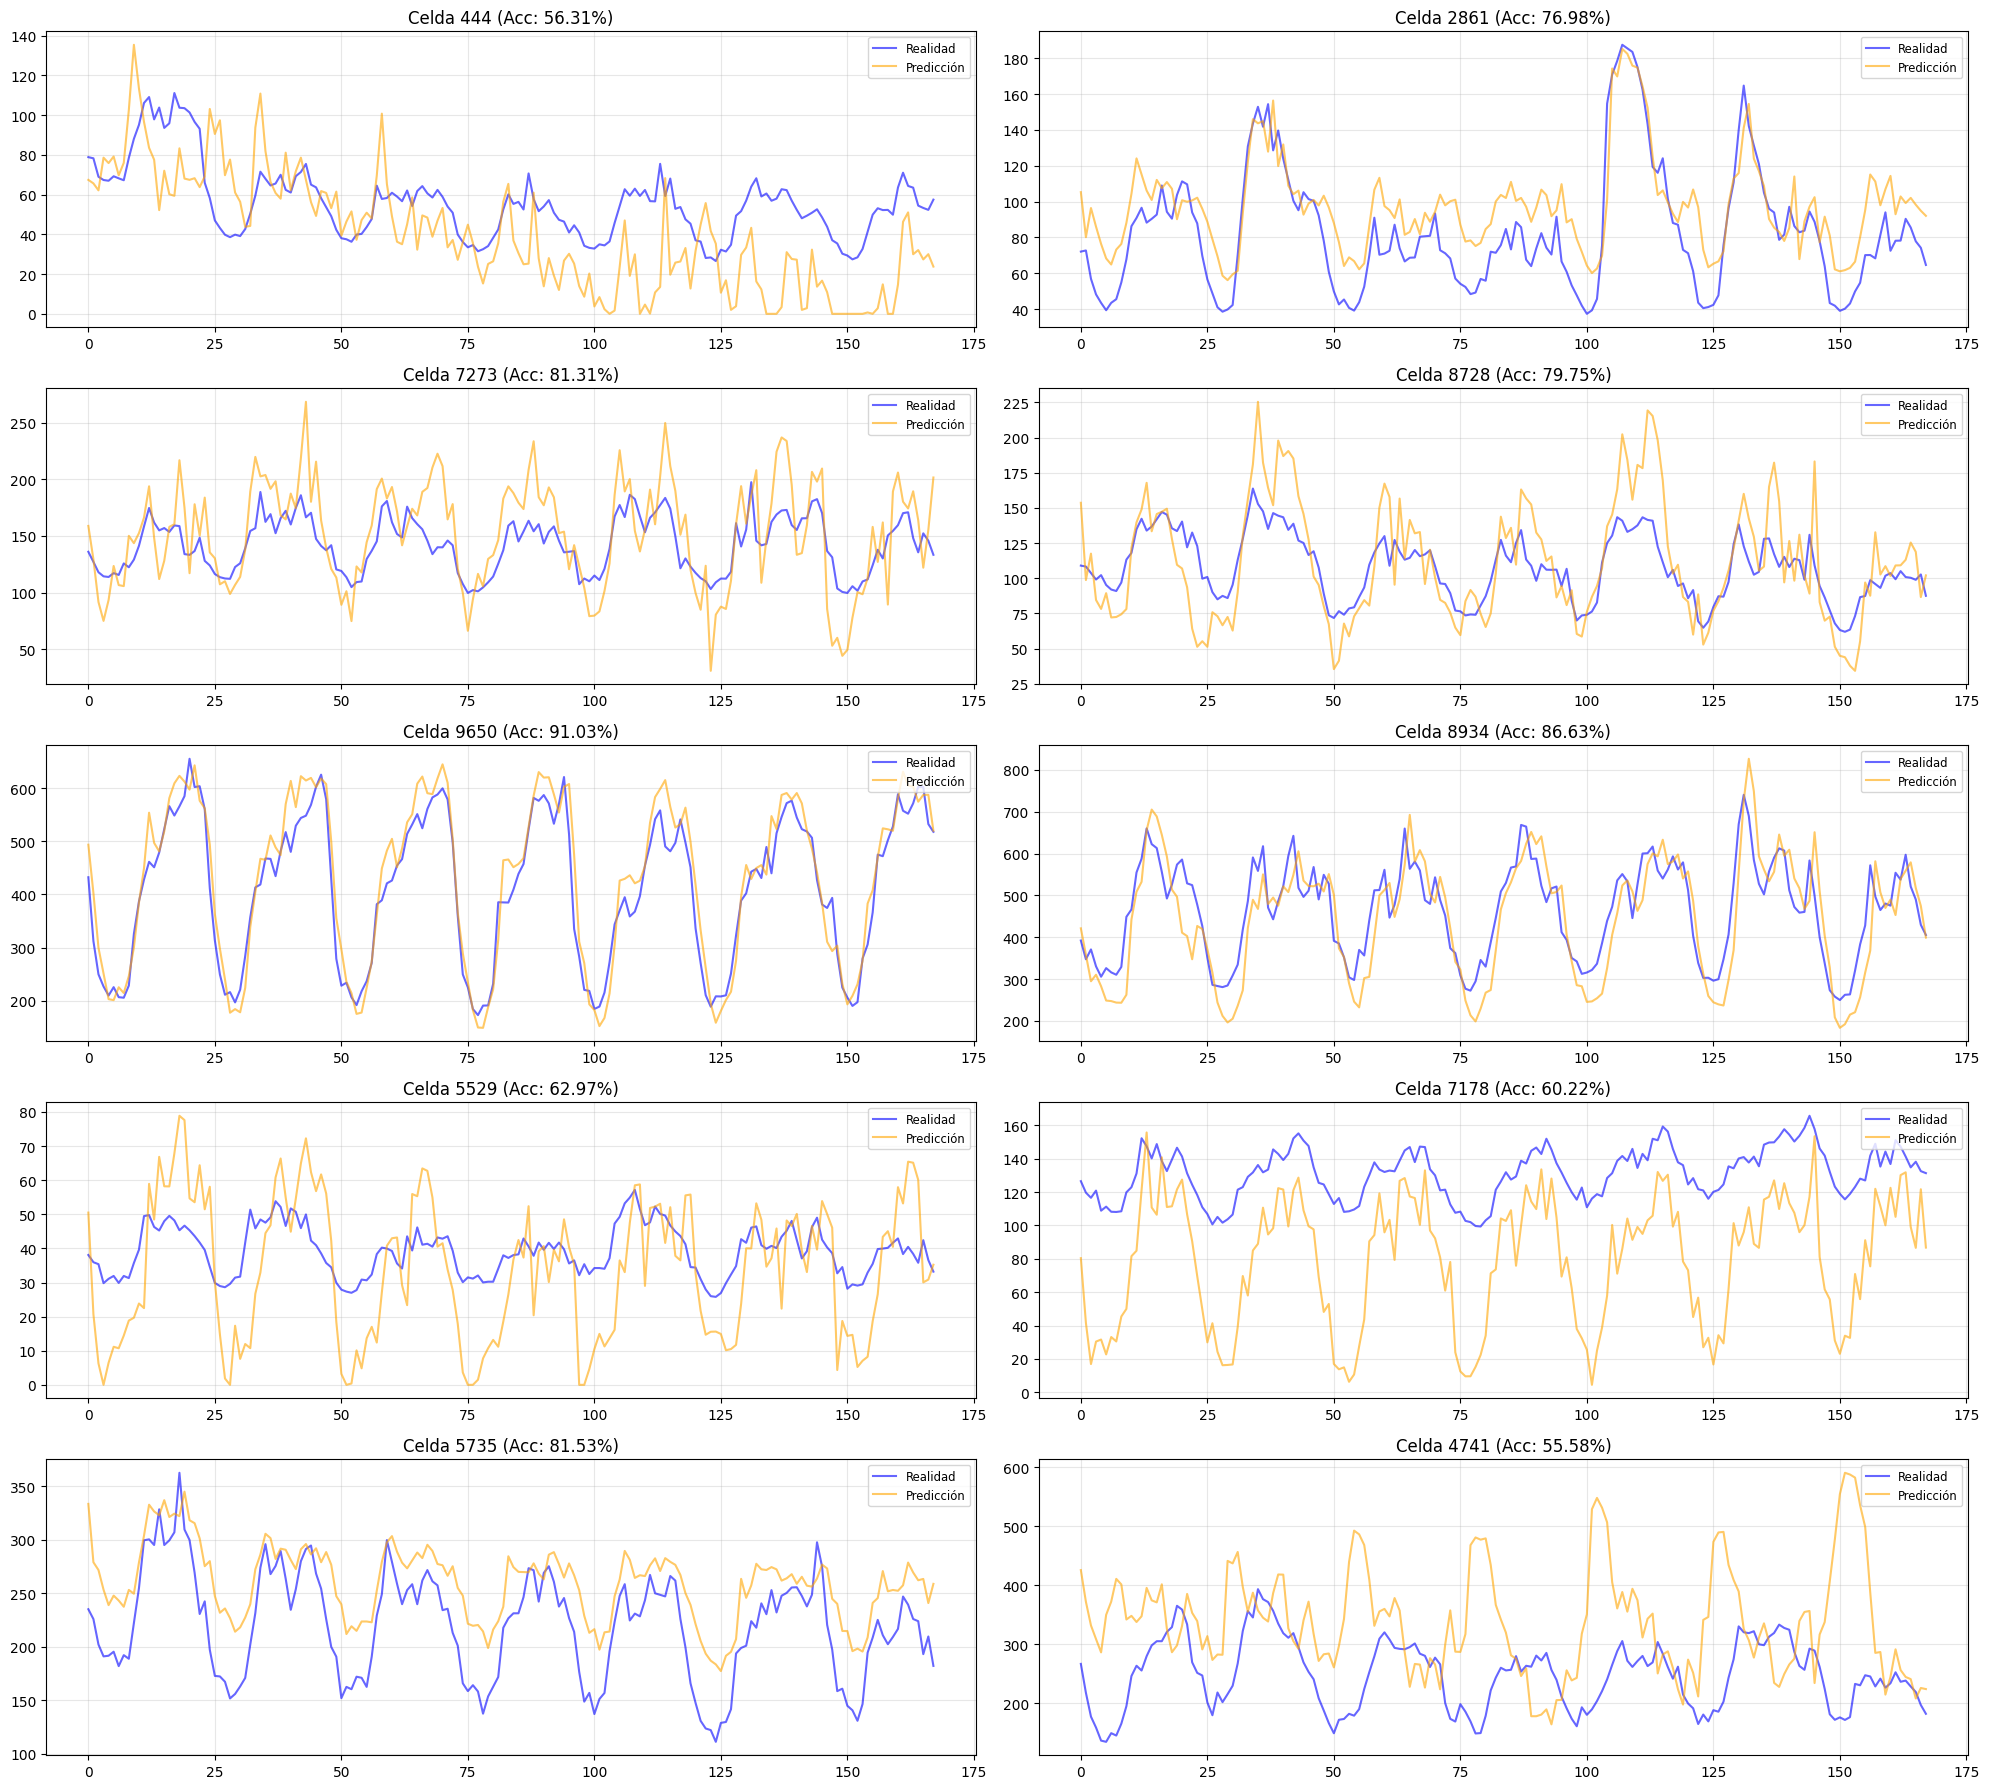

In [23]:
# --- EVALUACIÓN ROBUSTA (Ahorro de Memoria) CON VISUALIZACIÓN ---
import gc
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Limpiar memoria previa
torch.cuda.empty_cache()
gc.collect()

model.eval()
all_preds = []
all_reals = []

print("Calculando métricas finales (Modo Ahorro de RAM)...")
with torch.no_grad():
    for x_c, x_p, y in test_loader:
        x_c, x_p, y = x_c.to(DEVICE), x_p.to(DEVICE), y.to(DEVICE)
        output = model(x_c, x_p)
        
        # Des-normalizar Z-Score y convertir a float32
        pred = (output.cpu().numpy() * data_std.item() + data_mean.item()).astype(np.float32)
        real = (y.cpu().numpy() * data_std.item() + data_mean.item()).astype(np.float32)
        
        # Redimensionar a [Batch, Nodes] para facilitar indexación
        all_preds.append(pred.reshape(pred.shape[0], -1))
        all_reals.append(real.reshape(real.shape[0], -1))
        
        del output, pred, real

# Concatenación eficiente de resultados
preds_struct = np.concatenate(all_preds, axis=0)
reals_struct = np.concatenate(all_reals, axis=0)
del all_preds, all_reals
gc.collect()

# Asegurar que no hay predicciones negativas de tráfico
preds_struct = np.maximum(preds_struct, 0)

# 1. Cálculo de Métricas Globales
preds_flat = preds_struct.flatten()
reals_flat = reals_struct.flatten()

rmse = np.sqrt(mean_squared_error(reals_flat, preds_flat))
mae = mean_absolute_error(reals_flat, preds_flat)
wmape = np.sum(np.abs(reals_flat - preds_flat)) / (np.sum(np.abs(reals_flat)) + 1e-7)
accuracy = 1 - wmape

print(f"\nResultados de Evaluación:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"Accuracy (1-WMAPE): {accuracy:.4%}")

# Limpiar aplanados para liberar RAM antes de las gráficas
del preds_flat, reals_flat
gc.collect()

# --- VISUALIZACIÓN ---

# A. Nodo con mayor tráfico promedio
mean_traffic = reals_struct.mean(axis=0)
max_node_idx = np.argmax(mean_traffic)
print(f"Visualizando nodo crítico (Max Tráfico): {max_node_idx}")

plt.figure(figsize=(15, 5))
plt.plot(reals_struct[:, max_node_idx], label='Realidad', color='blue', alpha=0.7)
plt.plot(preds_struct[:, max_node_idx], label='Predicción', color='orange', alpha=0.7)
plt.title(f'Nodo {max_node_idx} (Máximo Tráfico)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# B. 10 Celdas Aleatorias
num_plots = 10
total_nodes = reals_struct.shape[1]
random_indices = np.random.choice(total_nodes, size=num_plots, replace=False)
print(f"Visualizando {num_plots} celdas aleatorias: {random_indices}")

fig, axes = plt.subplots(5, 2, figsize=(20, 18))
axes = axes.flatten()

for i, node_idx in enumerate(random_indices):
    ax = axes[i]
    ax.plot(reals_struct[:, node_idx], label='Realidad', color='blue', alpha=0.6)
    ax.plot(preds_struct[:, node_idx], label='Predicción', color='orange', alpha=0.6)
    
    # Cálculo de Accuracy local para este nodo
    local_err = np.sum(np.abs(reals_struct[:, node_idx] - preds_struct[:, node_idx]))
    local_sum = np.sum(np.abs(reals_struct[:, node_idx]))
    local_acc = 1 - (local_err / (local_sum + 1e-7))
    
    ax.set_title(f'Celda {node_idx} (Acc: {local_acc:.2%})')
    ax.legend(loc='upper right', fontsize='small')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()